## IBM AI Enterprise Workflow Capstone. 
## (Using data of the IBM AI Enterprise Workflow Capstone project)

## Case study part 1

1) Import modules & define functions

AN EXPLAINATION ABOUT FUNCTIONS (basically using samples from Solution Guidance)
-----
fetch_data: load all json formatted files into a dataframe

convert_to_ts: given the original DataFrame (fetch_data()), 
               return a numerically indexed time-series DataFrame by aggregating over each day

fetch_ts: convenience function to read in new data, 
          uses csv to load quickly (use clean=True when you want to re-create the files)

engineer_features: for any given day the target becomes the sum of the next days revenue, 
                   for that day we engineer several features that help predict the summed revenue

visualization: visualize the outcome of engineer_features by using matplotlib.pyplot


In [1]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

COLORS = ["darkorange","royalblue","slategrey"]

def fetch_data(data_dir):
    """
    load all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
            df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)


def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)


def fetch_ts(data_dir, clean=False):
    """
    convenience function to read in new data
    uses csv to load quickly
    use clean=True when you want to re-create the files
    """

    ts_data_dir = os.path.join(data_dir,"ts-data")
    
    if clean:
        shutil.rmtree(ts_data_dir)
    if not os.path.exists(ts_data_dir):
        os.mkdir(ts_data_dir)

    ## if files have already been processed load them        
    if len(os.listdir(ts_data_dir)) > 0:
        print("... loading ts data from files")
        return({re.sub("\.csv","",cf)[3:]:pd.read_csv(os.path.join(ts_data_dir,cf)) for cf in os.listdir(ts_data_dir)})

    ## get original data
    print("..... processing data")
    df = fetch_data(data_dir)

    ## find the top ten countries (wrt revenue)
    table = pd.pivot_table(df,index='country',values="price",aggfunc='sum')
    table.columns = ['total_revenue']
    table.sort_values(by='total_revenue',inplace=True,ascending=False)
    top_ten_countries =  np.array(list(table.index))[:10]

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    countries = [os.path.join(data_dir,"ts-"+re.sub("\s+","_",c.lower()) + ".csv") for c in top_ten_countries]

    ## load the data
    dfs = {}
    dfs['all'] = convert_to_ts(df)
    for country in top_ten_countries:
        country_id = re.sub("\s+","_",country.lower())
        file_name = os.path.join(data_dir,"ts-"+ country_id + ".csv")
        dfs[country_id] = convert_to_ts(df,country=country)

    ## save the data as csvs    
    for key, item in dfs.items():
        item.to_csv(os.path.join(ts_data_dir,"ts-"+key+".csv"),index=False)
        
    return(dfs)

def engineer_features(df,training=True):
    """
    for any given day the target becomes the sum of the next days revenue
    for that day we engineer several features that help predict the summed revenue
    
    the 'training' flag will trim data that should not be used for training
    when set to false all data will be returned

    """

    ## extract dates
    dates = df['date'].values.copy()
    dates = dates.astype('datetime64[D]')

    ## engineer some features
    eng_features = defaultdict(list)
    previous =[7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
    y = np.zeros(dates.size)
    for d,day in enumerate(dates):

        ## use windows in time back from a specific date
        for num in previous:
            current = np.datetime64(day, 'D') 
            prev = current - np.timedelta64(num, 'D')
            mask = np.in1d(dates, np.arange(prev,current,dtype='datetime64[D]'))
            eng_features["previous_{}".format(num)].append(df[mask]['revenue'].sum())

        ## get get the target revenue    
        plus_30 = current + np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(current,plus_30,dtype='datetime64[D]'))
        y[d] = df[mask]['revenue'].sum()

        ## attempt to capture monthly trend with previous years data (if present)
        start_date = current - np.timedelta64(365,'D')
        stop_date = plus_30 - np.timedelta64(365,'D')
        mask = np.in1d(dates, np.arange(start_date,stop_date,dtype='datetime64[D]'))
        eng_features['previous_year'].append(df[mask]['revenue'].sum())

        ## add some non-revenue features
        minus_30 = current - np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(minus_30,current,dtype='datetime64[D]'))
        eng_features['recent_invoices'].append(df[mask]['unique_invoices'].mean())
        eng_features['recent_views'].append(df[mask]['total_views'].mean())

    X = pd.DataFrame(eng_features)
    ## combine features in to df and remove rows with all zeros
    X.fillna(0,inplace=True)
    mask = X.sum(axis=1)>0
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)

    if training == True:
        ## remove the last 30 days (because the target is not reliable)
        mask = np.arange(X.shape[0]) < np.arange(X.shape[0])[-30]
        X = X[mask]
        y = y[mask]
        dates = dates[mask]
        X.reset_index(drop=True, inplace=True)
    
        
    return(X,y,dates) 

def visualization(ef):

    X,y,dates = engineer_features(df_time, training=True)

    dfplot1 = X[['previous_7']].copy()
    dfplot2 = X[['previous_35']].copy()
    dfplot3 = X[['previous_70']].copy()
    
    fig = plt.figure(figsize=(10.0, 8.0))
    ax = fig.add_subplot(111)
    plt.title('PREVIOUS 7/35/70 DAYS REVENUE ON THE DATE', fontsize=18)
    plt.xlabel('DATE', fontsize=18)
    plt.ylabel('REVENUE', fontsize=18)
    plt.plot(dates, dfplot1, "r", label="pre7days")
    plt.plot(dates, dfplot2, "c", label="pre35days")
    plt.plot(dates, dfplot3, "g", label="pre70days")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    plt.show()

    return()

2) Execute funtions

In [2]:
if __name__ == "__main__":

    run_start = time.time() 
    ## load data (you may need to adjust the location of the data to match your system)
    data_dir = os.path.join("c:\\","data_ml","cs-train")
    
    print("...reading data to store pd dataframe")    
    df = fetch_data(data_dir)
    print(df)
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("")
    print("load time:", "%d:%02d:%02d"%(h, m, s))

...reading data to store pd dataframe
               country  customer_id  day invoice  month  price stream_id  \
0       United Kingdom      13085.0   28  489434     11   6.95     85048   
1       United Kingdom      13085.0   28  489434     11   6.75    79323W   
2       United Kingdom      13085.0   28  489434     11   2.10     22041   
3       United Kingdom      13085.0   28  489434     11   1.25     21232   
4       United Kingdom      13085.0   28  489434     11   1.65     22064   
...                ...          ...  ...     ...    ...    ...       ...   
815006  United Kingdom      16098.0   31  562271      7   3.75     22725   
815007  United Kingdom      16098.0   31  562271      7   3.75     22726   
815008  United Kingdom      16098.0   31  562271      7   3.75     22727   
815009  United Kingdom      14056.0   31  562269      7   2.95     22090   
815010  United Kingdom      15628.0   31  562163      7   1.65     22558   

        times_viewed  year invoice_date  
0      

In [3]:
if __name__ == "__main__":

    run_start = time.time() 
    ## load data (you may need to adjust the location of the data to match your system)
    data_dir = os.path.join("c:\\","data_ml","cs-train")
    
    print("...reading data to store pd dataframe")    
    df_time = convert_to_ts(df, country=None)
    print(df_time)
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("")
    print("load time:", "%d:%02d:%02d"%(h, m, s))


...reading data to store pd dataframe
          date  purchases  unique_invoices  unique_streams  total_views  \
0   2017-11-01          0                0               0            0   
1   2017-11-02          0                0               0            0   
2   2017-11-03          0                0               0            0   
3   2017-11-04          0                0               0            0   
4   2017-11-05          0                0               0            0   
..         ...        ...              ...             ...          ...   
602 2019-06-26       1358               67             999         6420   
603 2019-06-27       1620               80             944         9435   
604 2019-06-28       1027               70             607         5539   
605 2019-06-29          0                0               0            0   
606 2019-06-30        602               27             423         2534   

    year_month  revenue  
0      2017-11     0.00  
1      20

In [4]:
if __name__ == "__main__":

    run_start = time.time() 
    ## load data (you may need to adjust the location of the data to match your system)
    data_dir = os.path.join("c:\\","data_ml","cs-train")
    
    print("...fetching data to make csv")
    ts_all = fetch_ts(data_dir, clean=True)
    
    for key,item in ts_all.items():
        print(key,item.shape)
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("")
    print("load time:", "%d:%02d:%02d"%(h, m, s))

...fetching data to make csv
..... processing data
all (607, 7)
united_kingdom (607, 7)
eire (607, 7)
germany (607, 7)
france (607, 7)
norway (577, 7)
spain (607, 7)
hong_kong (426, 7)
portugal (607, 7)
singapore (456, 7)
netherlands (607, 7)

load time: 0:00:55


In [5]:
if __name__ == "__main__":

    run_start = time.time() 
    
    print("...making engineer features")
    ef = engineer_features(df_time, training=True)
    print(ef)
    
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("")
    print("load time:", "%d:%02d:%02d"%(h, m, s))


...making engineer features
(     previous_7  previous_14  previous_21  previous_28  previous_35  \
0      14450.54     14450.54     14450.54     14450.54     14450.54   
1      27862.50     27862.50     27862.50     27862.50     27862.50   
2      41152.75     41152.75     41152.75     41152.75     41152.75   
3      50840.03     50840.03     50840.03     50840.03     50840.03   
4      52283.29     52283.29     52283.29     52283.29     52283.29   
..          ...          ...          ...          ...          ...   
544    35654.01     88316.24    134298.32    184306.67    203106.18   
545    23045.09     67418.62    125552.84    184306.67    203106.18   
546    20834.33     62382.30    115148.67    160811.46    199662.66   
547    22111.84     62893.44    115010.27    163049.25    201222.79   
548    24896.97     62197.61    113527.60    163867.77    203581.72   

     previous_42  previous_49  previous_56  previous_63  previous_70  \
0       14450.54    14450.540    14450.540    

...vizualization


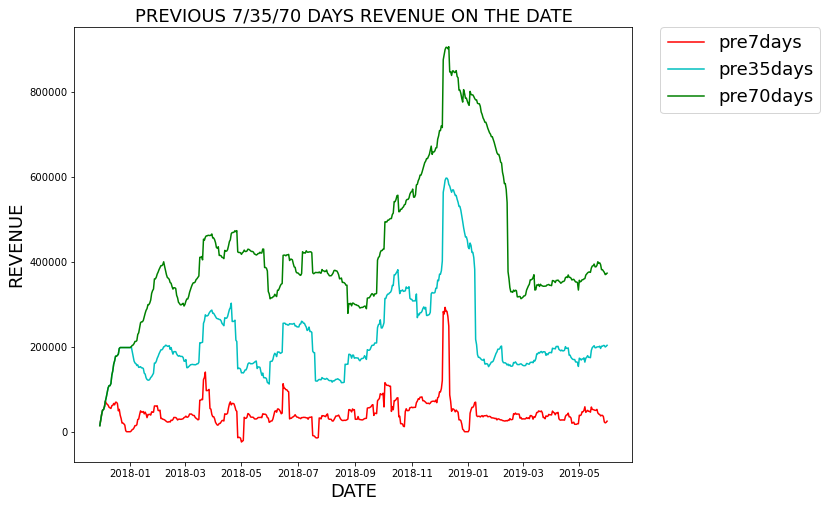


load time: 0:00:07


In [6]:
if __name__ == "__main__":

    run_start = time.time() 
    
    print("...vizualization")
    vis = visualization(ef)
    vis
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("")
    print("load time:", "%d:%02d:%02d"%(h, m, s))

COMMENT ON GRAPH

1. Winter (especially December) is the most profitable season, although already it seems to be known to HQ and managers.
2. Previous 70/35/7 days revenues are turned to similar, therefore it could be possible that focusing near-term stocks. 

## Case study part 2

1) Import modules & define functions

AN EXPLAINATION ABOUT FUNCTIONS (USING SAMPLES FROM Solution Guidance)
-----
logging_test: test to make a log file 

_model_train: example funtion to train model 

model_train: funtion to train model given a df

model_load: example funtion to load model (The prefix allows the loading of different models)

model_predict: example funtion to predict from model


In [7]:
import time,os,re,csv,sys,uuid,joblib
import warnings
from datetime import date
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

import logging 
from cslib import fetch_ts, engineer_features

## model specific variables (iterate the version and note with each change)
MODEL_DIR = os.path.join("c:\\","data_ml","cs-train","models")
MODEL_VERSION = 0.1
MODEL_VERSION_NOTE = "supervised learing model for time-series"


def logging_test():
    
    time_start = time.time()

    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)

    ## update log    
    logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(message)s', level=logging.INFO)
    logging.info('Logging test time was %s model_version:%s note:%s', runtime, MODEL_VERSION, MODEL_VERSION_NOTE)

def _model_train(df,tag,test=False):
    """
    example funtion to train model
    
    The 'test' flag when set to 'True':
        (1) subsets the data and serializes a test version
        (2) specifies that the use of the 'test' log file 

    """
    warnings.filterwarnings('ignore')

    ## start timer for runtime
    time_start = time.time()
    
    X,y,dates = engineer_features(df)

    if test:
        n_samples = int(np.round(0.3 * X.shape[0]))
        subset_indices = np.random.choice(np.arange(X.shape[0]),n_samples,
                                          replace=False).astype(int)
        mask = np.in1d(np.arange(y.size),subset_indices)
        y=y[mask]
        X=X[mask]
        dates=dates[mask]
        
    ## Perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        shuffle=True, random_state=42)
    ## train a random forest model
    param_grid_rf = {
    'rf__criterion': ['mse','mae'],
    'rf__n_estimators': [10,15,20,25]
    }

    pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                              ('rf', RandomForestRegressor())])
    
    grid = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, iid=False, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    eval_rmse =  round(np.sqrt(mean_squared_error(y_test,y_pred)))
    
    ## retrain using all data
    grid.fit(X, y)
    model_name = re.sub("\.","_",str(MODEL_VERSION))
    if test:
        saved_model = os.path.join(MODEL_DIR,
                                   "test-{}-{}.joblib".format(tag,model_name))
        print("... saving test version of model: {}".format(saved_model))
    else:
        saved_model = os.path.join(MODEL_DIR,
                                   "sl-{}-{}.joblib".format(tag,model_name))
        print("... saving model: {}".format(saved_model))
        
    joblib.dump(grid,saved_model)

    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)

    ## update log    
    logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(message)s', level=logging.INFO)
    logging.info('Training time was %s model_version:%s note:%s', runtime, MODEL_VERSION, MODEL_VERSION_NOTE)
    

def model_train(data_dir,test=False):
    """
    funtion to train model given a df
    
    'mode' -  can be used to subset data essentially simulating a train
    """
    
    if not os.path.isdir(MODEL_DIR):
        os.mkdir(MODEL_DIR)

    if test:
        print("... test flag on")
        print("...... subseting data")
        print("...... subseting countries")
        
    ## fetch time-series formatted data
    ts_data = fetch_ts(data_dir, clean=True)

    ## train a different model for each data sets
    for country,df in ts_data.items():
        
        if test and country not in ['all','united_kingdom']:
            continue
        
        _model_train(df,country,test=test)

    
    
def model_load(prefix='sl',data_dir=None,training=True):
    """
    example funtion to load model
    
    The prefix allows the loading of different models
    """
    time_start = time.time()

    if not data_dir:
        data_dir = os.path.join("c:\\","data_ml","cs-train")
    
#    models = [f for f in os.listdir(os.path.join(".","models")) if re.search("sl",f)]
#    models = [f for f in os.listdir(os.path.join("c:\\","data_ml","cs-train","models")) if re.search("sl",f)]
    models = [f for f in os.listdir(os.path.join("c:\\","data_ml","cs-train","models"))]

    if len(models) == 0:
        raise Exception("Models with prefix '{}' cannot be found did you train?".format(prefix))

    all_models = {}
    for model in models:
        all_models[re.split("-",model)[1]] = joblib.load(os.path.join("c:\\","data_ml","cs-train","models",model))

    ## load data
    ts_data = fetch_ts(data_dir)
    all_data = {}
    for country, df in ts_data.items():
        X,y,dates = engineer_features(df,training=training)
        dates = np.array([str(d) for d in dates])
        all_data[country] = {"X":X,"y":y,"dates": dates}
    
    
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)

    ## update log    
    logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(message)s', level=logging.INFO)
    logging.info('Loading time was %s model_version:%s note:%s', runtime, MODEL_VERSION, MODEL_VERSION_NOTE)
    
    
    return(all_data, all_models)



def model_predict(country,year,month,day,all_models=None,test=False):
    """
    example funtion to predict from model
    """

    ## start timer for runtime
    time_start = time.time()

    ## load model if needed
    if not all_models:
        all_data,all_models = model_load(training=False)
    
    ## input checks
    if country not in all_models.keys():
        raise Exception("ERROR (model_predict) - model for country '{}' could not be found".format(country))

    for d in [year,month,day]:
        if re.search("\D",d):
            raise Exception("ERROR (model_predict) - invalid year, month or day")
    
    ## load data
    model = all_models[country]
    data = all_data[country]

    ## check date
    target_date = "{}-{}-{}".format(year,str(month).zfill(2),str(day).zfill(2))
    print(target_date)

    if target_date not in data['dates']:
        raise Exception("ERROR (model_predict) - date {} not in range {}-{}".format(target_date,
                                                                                    data['dates'][0],
                                                                                    data['dates'][-1]))
    date_indx = np.where(data['dates'] == target_date)[0][0]
    query = data['X'].iloc[[date_indx]]
    
    ## sainty check
    if data['dates'].shape[0] != data['X'].shape[0]:
        raise Exception("ERROR (model_predict) - dimensions mismatch")

    ## make prediction and gather data for log entry
    y_pred = model.predict(query)
    y_proba = None
    if 'predict_proba' in dir(model) and 'probability' in dir(model):
        if model.probability == True:
            y_proba = model.predict_proba(query)


    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)

    ## update predict log
    logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s - %(message)s', level=logging.INFO)
    logging.info('Predicting time was %s model_version:%s note:%s', runtime, MODEL_VERSION, MODEL_VERSION_NOTE)
    
    return({'y_pred':y_pred,'y_proba':y_proba})




2) Execute funtions

In [8]:
if __name__ == "__main__":

    ## Logging test
    print("LOGGING TEST")
    logging_test()
    

LOGGING TEST


In [9]:
if __name__ == "__main__":

    ## train the model
    print("TRAINING MODELS")
    ## load data (you may need to adjust the location of the data to match your system)
    data_dir = os.path.join("c:\\","data_ml","cs-train")
    
    model_train(data_dir,test=False)
    

TRAINING MODELS
..... processing data
... saving model: c:\data_ml\cs-train\models\sl-all-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-united_kingdom-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-eire-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-germany-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-france-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-norway-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-spain-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-hong_kong-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-portugal-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-singapore-0_1.joblib
... saving model: c:\data_ml\cs-train\models\sl-netherlands-0_1.joblib


In [10]:
if __name__ == "__main__":

    ## load the model
    print("LOADING MODELS")
    all_data, all_models = model_load()
    print("... models loaded: ",",".join(all_models.keys()))


LOADING MODELS
... loading ts data from files
... models loaded:  all,eire,france,germany,hong_kong,netherlands,norway,portugal,singapore,spain,united_kingdom


In [11]:
if __name__ == "__main__":

    ## test predict
    print("PREDICT")
    country='all'
    year='2018'
    month='01'
    day='05'
    result = model_predict(country,year,month,day)
    print(result)

PREDICT
... loading ts data from files
2018-01-05
{'y_pred': array([184061.6545]), 'y_proba': None}


## Case study part 3

1) Import modules & define functions

AN EXPLAINATION ABOUT FUNCTIONS (USING SAMPLES FROM Docker tutorial)
-----


In [12]:
import os
import sys
import joblib
import requests
import numpy as np
import pandas as pd

2) Write outcomes to files (using DOCKER)

In [13]:
%%writefile app.py

from flask import Flask, jsonify, request
import joblib
import socket
import json
import pandas as pd
import os


## define model and data location (you may need to adjust the location of the data to match your system)
MODEL_DIR = os.path.join("c:\\","data_ml","cs-train","models")
DATA_DIR = os.path.join("c:\\","data_ml","cs-train")

app = Flask(__name__)

@app.route("/")
def hello():
    html = "<h3>Hello {name}!</h3>" \
           "<b>Hostname:</b> {hostname}<br/>"
    return html.format(name=os.getenv("NAME", "world"), hostname=socket.gethostname())

@app.route('/predict', methods=['GET','POST'])
def predict():
    
    ## input checking
    if not request.json:
        print("ERROR: API (predict): did not receive request data")
        return jsonify([])

    query = request.json['query']
    
    ## load model
    all_data, all_models = model_load()
    
        if not model:
        print("ERROR: model is not available")
        return jsonify([])
    
    result = model_predict(query)
    
    return(jsonify(result))
            
if __name__ == '__main__':

    if args["debug"]:
        app.run(debug=True, port=8080)
    else:
        app.run(host='0.0.0.0', threaded=True ,port=8080)


Overwriting app.py


In [14]:
%%writefile requirements.txt

cython
numpy
flask
pandas
scikit-learn

Overwriting requirements.txt


In [15]:
%%writefile Dockerfile

# Use an official Python runtime as a parent image
FROM python:3.7.5-stretch

RUN apt-get update && apt-get install -y \
python3-dev \
build-essential    
        
# Set the working directory to /app
WORKDIR /app

# Copy the current directory contents into the container at /app
ADD . /app

# Install any needed packages specified in requirements.txt
RUN pip install --upgrade pip
RUN pip install --no-cache-dir -r requirements.txt

# Make port 80 available to the world outside this container
EXPOSE 80

# Define environment variable
ENV NAME World

# Run app.py when the container launches
CMD ["python", "app.py"]

Overwriting Dockerfile


In [16]:
## create some new data
X_new_data = {}
X_new_data['country'] = ['all']
X_new_data['year'] = ['2018']
X_new_data['month'] = ['01']
X_new_data['day'] = ['05']
X_new = pd.DataFrame(X_new_data)
X_new.head()

,country,year,month,day
0,all,2018,01,05


In [17]:
import requests

## data needs to be in dict format for JSON
query = X_new.to_dict()

## test the Flask API
port = 8080
r = requests.post('http://0.0.0.0:{}/predict'.format(port),json=query)

## test the Docker API
port = 8080
r = requests.post('http://0.0.0.0:{}/predict'.format(port),json=query)

result = model_predict(query)
print(result)

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8080): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022AEA225AC0>: Failed to establish a new connection: [WinError 10049] 要求したアドレスのコンテキストが無効です。'))